This script serves as a wrapper for the empirical eBOSC example.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from ebosc.helpers import get_project_root
from ebosc.eBOSC_wrapper import eBOSC_wrapper

**Specify paths**

In [4]:
pn = dict()
pn['root']  = os.path.abspath(os.path.dirname(get_project_root()))
pn['examplefile'] = os.path.join(pn['root'],'data','1160_rest_EEG_Rlm_Fhl_rdSeg_Art_EC.csv')
pn['outfile'] = os.path.join(pn['root'],'data','example_out.npy')

**eBOSC parameters**

In [5]:
cfg_eBOSC = dict()
cfg_eBOSC['F'] = 2 ** np.arange(1,6,.125)   # frequency sampling
cfg_eBOSC['wavenumber'] = 6                 # wavelet parameter (time-frequency tradeoff)
cfg_eBOSC['fsample'] = 500                  # current sampling frequency of EEG data
cfg_eBOSC['pad.tfr_s'] = 1                  # padding following wavelet transform to avoid edge artifacts in seconds (bi-lateral)
cfg_eBOSC['pad.detection_s'] = .5           # padding following rhythm detection in seconds (bi-lateral); 'shoulder' for BOSC eBOSC.detected matrix to account for duration threshold
cfg_eBOSC['pad.background_s'] = 1           # padding of segments for BG (only avoiding edge artifacts)

*Threshold settings*

In [6]:
cfg_eBOSC['threshold.excludePeak'] = np.array([[8,15]])   # lower and upper bound of frequencies to be excluded during background fit (Hz) (previously: LowFreqExcludeBG HighFreqExcludeBG)
cfg_eBOSC['threshold.duration'] = np.kron(np.ones((1,len(cfg_eBOSC['F']))),3) # vector of duration thresholds at each frequency (previously: ncyc)
cfg_eBOSC['threshold.percentile'] = .95    # percentile of background fit for power threshold

*Rhythmic episode post-processing*

In [7]:
cfg_eBOSC['postproc.use'] = 'yes'           # Post-processing of rhythmic eBOSC.episodes, i.e., wavelet 'deconvolution' (default = 'no')
cfg_eBOSC['postproc.method'] = 'FWHM'       # Deconvolution method (default = 'MaxBias', FWHM: 'FWHM')
cfg_eBOSC['postproc.edgeOnly'] = 'yes'      # Deconvolution only at on- and offsets of eBOSC.episodes? (default = 'yes')
cfg_eBOSC['postproc.effSignal'] = 'PT'      # Power deconvolution on whole signal or signal above power threshold? (default = 'PT')

*General processing settings*

In [8]:
cfg_eBOSC['channel'] = ['Oz']            # select posterior channels (default: all)
cfg_eBOSC['trial'] = []                  # select trials (default: all, indicate in natural trial number (not zero-starting))
cfg_eBOSC['trial_background'] = []       # select trials for background (default: all, indicate in natural trial number (not zero-starting))

**Load example data**<br> (see /data folder)

In [9]:
data = pd.read_csv(pn['examplefile'])

**Concatenate trials for resting state here (pseudo-continuous)**<br>
- more specifically, treat all data as a single trial
- uncomment this line if you are interested in getting results for pseudotrials
- for simplicity, we will not deal with missing timepoints (i.e., hard edges) in the continuous data

In [10]:
data['epoch'].values[:] = 0

**Run eBOSC**

In [11]:
[eBOSC, cfg] = eBOSC_wrapper(cfg_eBOSC, data)

Channel: Oz; Nr. 1/1
Removing frequency peaks from the background
Trial Nr. 1/1
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Removing padding from detected episodes


**Plot avg. detected matrix across trials based on multiindex**

Note that the trial average is only plotted, if multiple trials/epochs were indicated in the original input data.
When data are concatenated, results pertain to a single trial here.

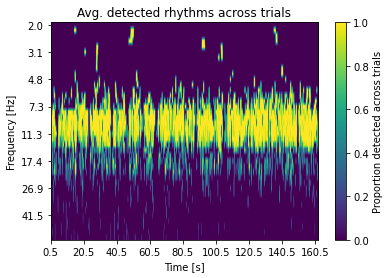

In [23]:
detected_avg = eBOSC['detected'].mean(level=['frequency', 'time'])
detected_avg = detected_avg.pivot_table(index=['frequency'], columns='time')
cur_multiindex = eBOSC['detected'].index
cur_time = cur_multiindex.get_level_values('time').unique()
cur_freq = cur_multiindex.get_level_values('frequency').unique()

fig, ax = plt.subplots(nrows=1, ncols=1)
im = ax.imshow(detected_avg, aspect = 'auto')
[x0, x1] = ax.get_xlim()
[y0, y1] = ax.get_ylim()
xticks_loc = [t for t in ax.get_xticks() if t>=x0 and t<=x1]
yticks_loc = [t for t in ax.get_yticks() if t>=y1 and t<=y0]
x_label_list = np.round(cur_time[np.int_(xticks_loc)],1).tolist()
y_label_list = np.round(cur_freq[np.int_(yticks_loc)],1).tolist()
ax.set_xticks(xticks_loc)
ax.set_xticklabels(x_label_list)
ax.set_yticks(yticks_loc)
ax.set_yticklabels(y_label_list)
plt.colorbar(im, label='Proportion detected across trials')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Avg. detected rhythms across trials', fontsize=12)
plt.show()

**Plot results from a selected channel and trial**

Here we select the first trial and first channel we encoded (see cfg.eBOSC.channel).

In [14]:
indChan = 1
indChan = indChan-1     # account for Python's zero-based indexing
indTrial = 1
indTrial = indTrial-1

In [15]:
print(['Results are for trial ' + str(cfg_eBOSC['trial'][indTrial]+1) + 
       ' at channel ' + cfg_eBOSC['channel'][indChan]])

['Results are for trial 1 at channel Oz']


get original time series for plotting

In [16]:
origData = data.loc[data['epoch']==indTrial, (cfg_eBOSC['channel'][indChan])].values
origData = origData[np.arange(cfg_eBOSC['pad.total_sample']+1, 
                              origData.shape[0]-cfg_eBOSC['pad.total_sample']+1)]

**Figure: plot estimated background + power threshold**

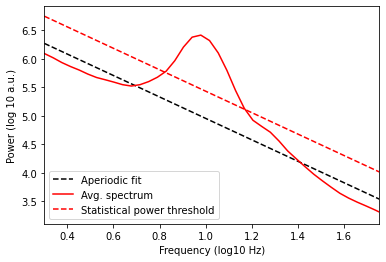

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)
h1, =plt.plot(np.log10(cfg_eBOSC['F']), np.log10(list(eBOSC['static.mp'].values[indChan,:])),'k--')
h1.set_label('Aperiodic fit')
h2, =plt.plot(np.log10(cfg_eBOSC['F']), list(eBOSC['static.bg_log10_pow'].values[indChan,:]),'r-')
h2.set_label('Avg. spectrum')
h3, =plt.plot(np.log10(cfg_eBOSC['F']), np.log10(list(eBOSC['static.pt'].values[indChan,:])),'r--')
h3.set_label('Statistical power threshold')
plt.xlabel('Frequency (log10 Hz)')
plt.ylabel('Power (log 10 a.u.)')
ax.legend()
ax.set_xlim([.3, 1.75])
plt.show()

**Figure: different episode statistics**

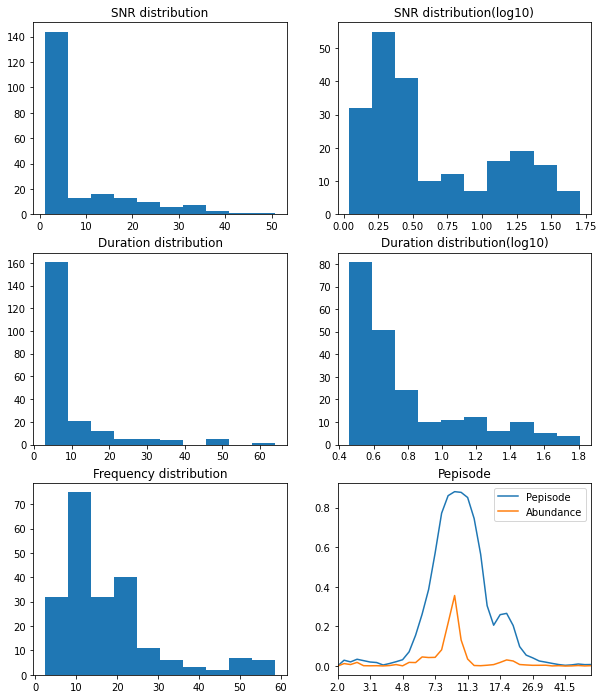

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=2,figsize=(10,12))
ax[0,0].hist(eBOSC['episodes']['SNRMean'])
ax[0,0].set_title('SNR distribution')
ax[0,1].hist(np.log10(eBOSC['episodes']['SNRMean']))
ax[0,1].set_title('SNR distribution(log10)')
ax[1,0].hist(eBOSC['episodes']['DurationC'])
ax[1,0].set_title('Duration distribution')
ax[1,1].hist(np.log10(eBOSC['episodes']['DurationC']))
ax[1,1].set_title('Duration distribution(log10)')
ax[2,0].hist(eBOSC['episodes']['FrequencyMean'])
ax[2,0].set_title('Frequency distribution')
tmp_pep = eBOSC['detected'].mean(level=['frequency']).values
[pep]=ax[2,1].plot(tmp_pep)
pep.set_label('Pepisode')
tmp_abn = eBOSC['detected_ep'].mean(level=['frequency']).values
[abn]=ax[2,1].plot(tmp_abn)
abn.set_label('Abundance')
ax[2,1].set_title('Pepisode')
ax[2,1].set_xlim([0, 39])
cur_multiindex = eBOSC['detected'].index
cur_freq = cur_multiindex.get_level_values('frequency').unique()
[x0, x1] = ax[2,1].get_xlim()
xticks_loc = [t for t in ax[2,1].get_xticks() if t>=x0 and t<=x1]
x_label_list = np.round(cur_freq[np.int_(xticks_loc)],1).tolist()
ax[2,1].set_xticks(xticks_loc)
ax[2,1].set_xticklabels(x_label_list)
ax[2,1].legend()
plt.show()

Note that abundance will always be smaller than Pepisode. However, the abundance values plotted here are somewhat misleading as the underlying data have been sparsened across frequencies, while allowing for frequency variability. An alpha rhyhthm may thus e.g., start at 9.5 Hz, transition to 10 Hz, and return to 9.5 Hz. This would spread 'abundance' to two frequencies. Thus, it makes sense to define a frequency range of interest (e.g., 8 - 12 Hz), and sum detected time points in this range for the final abundance calculation. 

**Figure: plot rhythmic episodes with indicated onsets**

filter for alpha by mean frequency (!) of episode

In [19]:
c1 = np.array(eBOSC['episodes']['FrequencyMean']) > 8
c2 = np.array(eBOSC['episodes']['FrequencyMean']) < 15
c3 = np.array(eBOSC['episodes']['Trial']) == indTrial+1
c4 = np.array(eBOSC['episodes']['Channel']) == cfg_eBOSC['channel'][indChan]
idx_alpha = np.where(np.logical_and(np.logical_and(np.logical_and(c1, c2),c3),c4))
idx_onset = []
idx_onsetTime = []
alphaDetected = np.zeros([len(origData)])
alphaDetected[alphaDetected==0] = np.nan
for indEp in idx_alpha[0]:
    # These are two alternative ways to extract the onset timepoint from the table
    idx_onsetTime.append(np.where(cfg_eBOSC['time.time_det']>= eBOSC['episodes']['Onset'][indEp])[0][0])
    idx_onset.append(eBOSC['episodes']['ColID'][indEp][0])
    # Mark all periods with episodes falling into the alpha range
    within_range = np.arange(eBOSC['episodes']['ColID'][indEp][0], 
                             eBOSC['episodes']['ColID'][indEp][-1]+1)
    alphaDetected[within_range] = 1

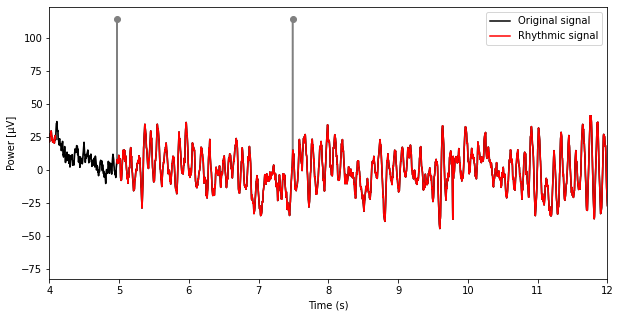

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
highlight_limit = max(origData)*2
plt.scatter(cfg_eBOSC['time.time_det'][idx_onset], 
            np.kron(np.ones((1,len(idx_onset))),highlight_limit), color=[.5, .5, .5])
OnsetLine = origData.copy()
OnsetLine[idx_onset] = highlight_limit
plt.plot(cfg_eBOSC['time.time_det'],OnsetLine, color=[.5, .5, .5])
[orig]=plt.plot(cfg_eBOSC['time.time_det'],origData, color='k')
orig.set_label('Original signal')
[rhythm]=plt.plot(cfg_eBOSC['time.time_det'],origData*alphaDetected, color='r')
rhythm.set_label('Rhythmic signal')
plt.xlabel('Time (s)')
plt.ylabel('Power [µV]')
ax.legend()
ax.set_xlim([4, 12])
plt.show()

**Optional: delete unnecessary fields prior to saving**

The 'detected matrices' encode binary matrices incl. every time point. As<br>
such, they may grow large in size. If those are not necessary for later<br>
analysis, they can be removed here.

In [ ]:
del eBOSC['detected']
del eBOSC['detected_ep']

If e.g., the column and row indices in the episode table are not needed,<br>
similarly delete them here.

In [ ]:
eBOSC['episodes']['RowID'] = []
eBOSC['episodes']['ColID'] = []

Additionally, it makes sense to save the cfg for later reference.

In [ ]:
eBOSC['cfg'] = cfg_eBOSC

**Save output dictionary**

In [ ]:
np.save(pn['outfile'], eBOSC)

**For further processing: load existing output file** <br>
eBOSC = np.load(pn['outfile'],allow_pickle='TRUE').item()